In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower

In [2]:
import scipy.integrate as integrate
import scipy.special as special     # for integrating special func.s such as elliptic, bessel, gamma, beta, hypergeometric, etc.
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
#Generate our own data here, setting specific cosmology:
pars = camb.CAMBparams()
h=67.5/100.0
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=[0.0], kmax=10.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints= 2000)          # 2000 elements in array, maxkh=20?
s8 = np.array(results.get_sigma8())

In [4]:
print(np.shape(kh))
print(np.shape(pk))

(2000,)
(1, 2000)


In [5]:
train_k = kh                                                                #np.arrays, sizes 2000
train_pk = pk[0]

In [6]:
print(np.shape(train_k))
print(np.shape(train_pk))

(2000,)
(2000,)


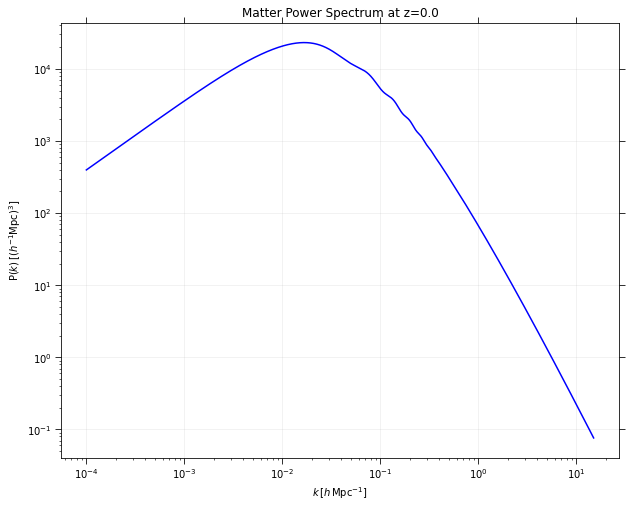

In [7]:
# Plot using training data:

plt.figure(figsize = (10,8))
plt.loglog(train_k, train_pk, 'b')
#plt.plot(, r_array, 'ro')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#plt.legend(['linear'], loc='lower left', fontsize=14);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

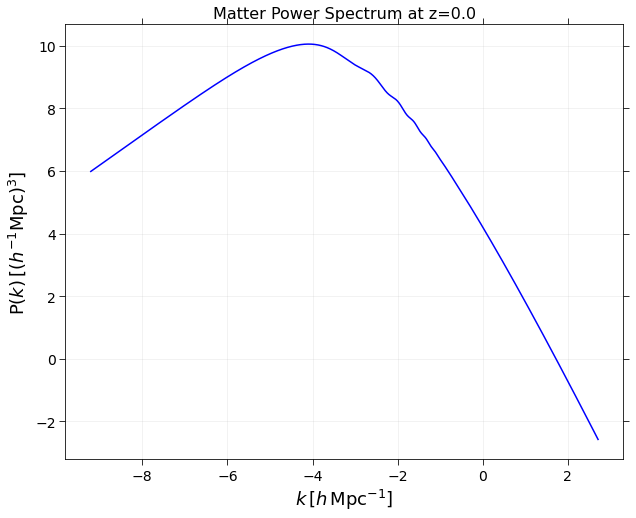

In [8]:
# Plot using training data:

plt.figure(figsize = (10,8))
plt.plot(np.log(train_k), np.log(train_pk), 'b')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#plt.legend(['linear'], loc='lower left', fontsize=14);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

In [9]:
# Standardising:

train_k_scaler = StandardScaler()
train_pk_scaler = StandardScaler()

# Storing the fit object for later reference
scaled_train_k = train_k_scaler.fit(np.log(train_k).reshape(-1,1)) 
scaled_train_pk = train_pk_scaler.fit(np.log(train_pk).reshape(-1,1))

# Generating the standardized values of X and y
X=scaled_train_k.transform(np.log(train_k).reshape(-1,1))
y=scaled_train_pk.transform(np.log(train_pk).reshape(-1,1))

In [10]:
print(np.shape(X))
print(np.shape(y))

(2000, 1)
(2000, 1)


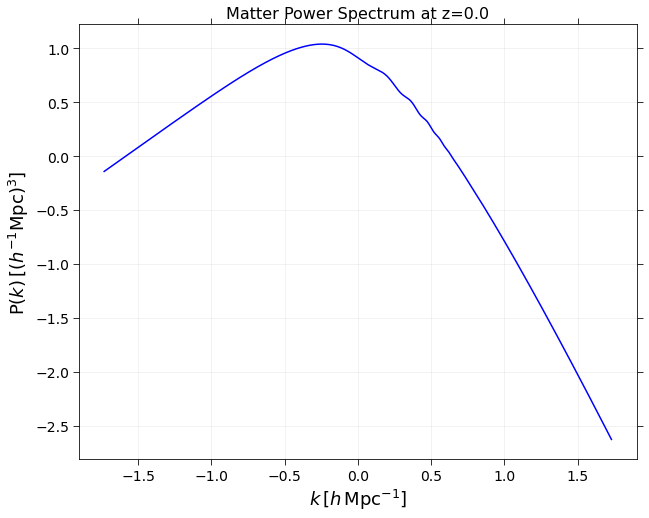

In [11]:
# Standardised plot:

plt.figure(figsize = (10,8))
plt.plot(X, y, 'b')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#plt.legend(['linear'], loc='lower left', fontsize=14);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

In [12]:
#print(X)

In [13]:
#print(y)

In [14]:
# Split the data into training and testing set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# initializing the internal random number generator, setting random_state a fixed value will guarantee that
# same sequence of random numbers are generated each time you run the code.

In [15]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(1600, 1)
(1600, 1)
(400, 1)
(400, 1)


In [16]:
# sort in ascending order:

zipped_lists = zip(X_train, y_train)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
X_train, y_train = [list(tuple) for tuple in  tuples]



print(X_train[1599])
print(y_train[1599])

[1.731185]
[-2.62787781]


In [17]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [18]:
type(X_train)

numpy.ndarray

In [27]:
X_train.shape[0]

1600

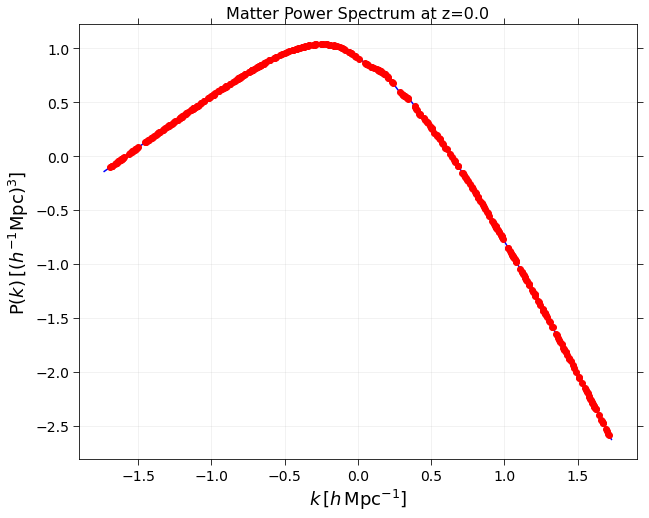

In [19]:
# Standardised plot of train and test:

plt.figure(figsize = (10,8))
plt.plot(X_train, y_train, 'b')
plt.plot(X_test, y_test, 'ro')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#plt.legend(['linear'], loc='lower left', fontsize=14);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

In [20]:
#Building the NN:

model = Sequential()
# Defining the first layer of the model
model.add(Dense(units=32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 20, epochs = 100, verbose=2)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - model.predict(X_test))/y_test))*100
# printing the results of the current iteration
#print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
print('Accuracy:', 100-MAPE)

Epoch 1/100
80/80 - 1s - loss: 0.8430 - 847ms/epoch - 11ms/step
Epoch 2/100
80/80 - 0s - loss: 0.2590 - 71ms/epoch - 893us/step
Epoch 3/100
80/80 - 0s - loss: 0.1236 - 61ms/epoch - 760us/step
Epoch 4/100
80/80 - 0s - loss: 0.0994 - 64ms/epoch - 797us/step
Epoch 5/100
80/80 - 0s - loss: 0.0802 - 58ms/epoch - 723us/step
Epoch 6/100
80/80 - 0s - loss: 0.0556 - 57ms/epoch - 711us/step
Epoch 7/100
80/80 - 0s - loss: 0.0311 - 60ms/epoch - 755us/step
Epoch 8/100
80/80 - 0s - loss: 0.0146 - 61ms/epoch - 760us/step
Epoch 9/100
80/80 - 0s - loss: 0.0066 - 64ms/epoch - 798us/step
Epoch 10/100
80/80 - 0s - loss: 0.0031 - 58ms/epoch - 729us/step
Epoch 11/100
80/80 - 0s - loss: 0.0016 - 62ms/epoch - 773us/step
Epoch 12/100
80/80 - 0s - loss: 9.1524e-04 - 64ms/epoch - 798us/step
Epoch 13/100
80/80 - 0s - loss: 6.4736e-04 - 61ms/epoch - 760us/step
Epoch 14/100
80/80 - 0s - loss: 4.7199e-04 - 56ms/epoch - 698us/step
Epoch 15/100
80/80 - 0s - loss: 3.9765e-04 - 56ms/epoch - 698us/step
Epoch 16/100
80/80

In [21]:
# Scaling the X data back to original scale
temp = X_train
temp2 = X_test

y_train_pred = scaled_train_pk.inverse_transform(model.predict(temp))
y_test_pred = scaled_train_pk.inverse_transform(model.predict(temp2))

X_train = scaled_train_k.inverse_transform(X_train)
X_test = scaled_train_k.inverse_transform(X_test)

# Scaling the y_test/train Price data back to original scale
y_train = scaled_train_pk.inverse_transform(y_train)
y_test = scaled_train_pk.inverse_transform(y_test)
    
# Scaling the test data back to original scale
#Test_Data = scaled_train_k.inverse_transform(X_test)

In [22]:
#Return to log scale:
X_train = np.exp(X_train)
y_train = np.exp(y_train)
X_test = np.exp(X_test)
y_test = np.exp(y_test)
prediction_train = np.exp(y_train_pred)
prediction_test = np.exp(y_test_pred)

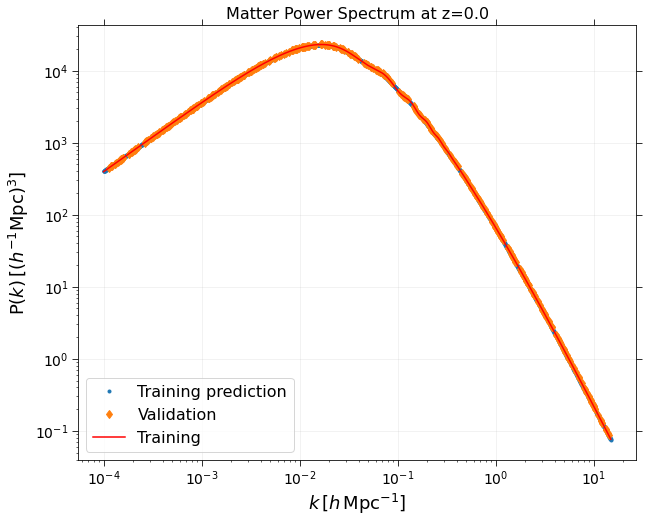

In [23]:
plt.figure(figsize = (10,8))                                             ###DONE!
plt.loglog(X_train, prediction_train, "C0.")         #blue line
plt.loglog(X_test, y_test, "C1d")
plt.loglog(kh, pk[0], 'r')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
plt.legend(['Training prediction','Validation', 'Training'], loc='lower left', fontsize=16);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

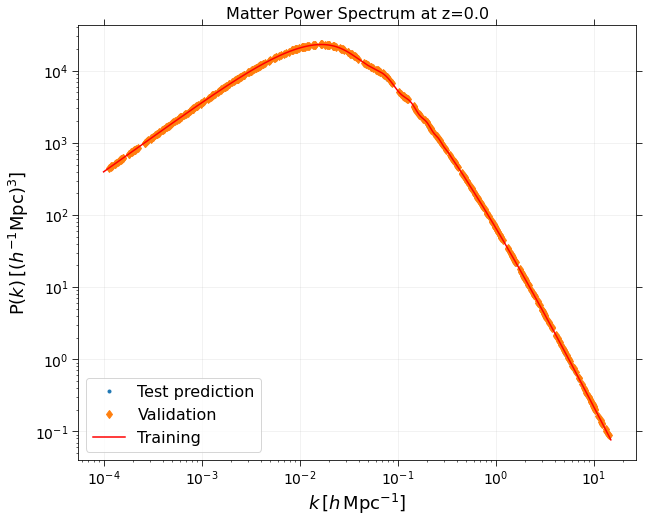

In [24]:
plt.figure(figsize = (10,8))                                             ###DONE!
plt.loglog(X_test, prediction_test, "C0.")         #blue line
plt.loglog(X_test, y_test, "C1d")
plt.loglog(kh, pk[0], 'r')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
plt.legend(['Test prediction','Validation', 'Training'], loc='lower left', fontsize=16);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()

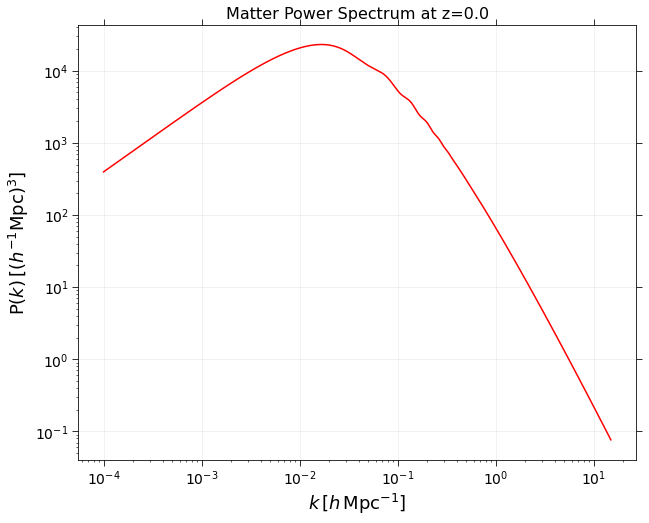

In [25]:
#ORIGINAL PLOT
plt.figure(figsize = (10,8))
plt.loglog(kh, pk[0], 'r')
#plt.plot(, r_array, 'ro')
plt.title('Matter Power Spectrum at z=0.0')
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=16)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
#plt.legend(['linear'], loc='lower left', fontsize=14);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.show()